In [42]:
# import libraries
%matplotlib inline
import pandas as pd
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

In [48]:
# get dataloaders
batch_size = 64

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=False, transform=transform)
validset = torchvision.datasets.MNIST(root='./data', train=False, download=False, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=validset, batch_size=batch_size, shuffle=False)

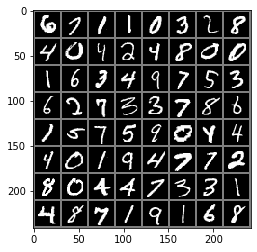

In [49]:
# show some images
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Conv2d(1, 20, 3, 1)
        self.maxpool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(20*13*13, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = F.relu(self.maxpool(self.conv(x)))
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        out = F.softmax(self.fc2(x))
        return out

In [5]:
def plot_losses(train_loss_list, valid_loss_list, img_PATH):
    
    plt.plot(train_loss_list, label='training loss')
    plt.plot(valid_loss_list, label='validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss per batch')
    plt.legend(loc='best')
    plt.title('Loss Per Batch')
    plt.savefig(img_PATH)

In [25]:
def plot_comparison(model_list, plot_train=True, start=0, figsize =(8, 5.5)):
    plt.figure(figsize=figsize)
    if plot_train:
        for model in model_list:
            loss = torch.load(model)['train_loss_list']
            plt.plot(loss[start:], label = model[7:-4])
        plt.title('Training loss vs. num of epochs')
    else:
        for model in model_list:
            loss = torch.load(model)['valid_loss_list']
            plt.plot(loss[start:], label = model[7:-4])
        plt.title('Validation loss vs. num of epochs')
    plt.xlabel('num of epochs')
    plt.ylabel('loss per batch')
    plt.legend(loc='best')
    plt.show()

In [39]:
def plot_acc_comparison(model_list, plot_train=True, start=0, figsize =(8, 5.5)):
    plt.figure(figsize=figsize)
    if plot_train:
        for model in model_list:
            loss = torch.load(model)['train_accuracy_list']
            plt.plot(loss[start:], label = model[7:-4])
        plt.title('Training accuracy vs. num of epochs')
    else:
        for model in model_list:
            loss = torch.load(model)['valid_accuracy_list']
            plt.plot(loss[start:], label = model[7:-4])
        plt.title('Validation accuracy vs. num of epochs')
    plt.xlabel('num of epochs')
    plt.ylabel('accuracy')
    plt.legend(loc='best')
    plt.show()

### General update

In [7]:
def train(model, PATH, batch_size=64, lr_seq=[], num_epochs=50, rate=0.01, 
         by_epoch=False, by_cutoff=False, by_oscillate=False):
    
    train_loss_list = []
    valid_loss_list = [0.0, 0.0]
    train_accuracy_list = []
    valid_accuracy_list = []
    lr_seq.reverse()
    start_time = time.time()
    for epoch in range(num_epochs):
        train_loss = 0.0
        train_accuracy = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_accuracy += (outputs.max(dim=1)[1] == labels).type(torch.FloatTensor).mean().item()
        train_loss = train_loss/len(train_loader)
        train_loss_list.append(train_loss)
        train_accuracy = train_accuracy/len(train_loader)
        train_accuracy_list.append(train_accuracy)
        
        model.eval()
        with torch.no_grad():
            valid_loss = 0.0
            valid_accuracy = 0.0
            for images, labels in valid_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                valid_loss += loss.item()
                valid_accuracy += (outputs.max(dim=1)[1] == labels).type(torch.FloatTensor).mean().item()
            valid_loss = valid_loss/len(valid_loader)
            valid_loss_list.append(valid_loss)
            valid_accuracy = valid_accuracy/len(valid_loader)
            valid_accuracy_list.append(valid_accuracy)
        
        print('epoch %5d   train loss: %.5f, train accuracy: %.5f, valid loss: %.5f, valid accuracy: %.5f' % 
              (epoch+1, train_loss, train_accuracy, valid_loss, valid_accuracy))
         
        if abs(valid_loss_list[-1] - valid_loss_list[-3]) < 1e-7:
            print('Model converges!')
            end_time = time.time()
            converge_time = end_time - start_time
            print("Running time is %g seconds" % (converge_time))
            valid_loss_list = valid_loss_list[2:]
            torch.save({'epoch': (epoch+1), 'model_state_dict': model.state_dict(), 
                'optimizer_state_dict': optimizer.state_dict(), 
               'train_loss_list': train_loss_list, 
                'valid_loss_list': valid_loss_list, 
                'train_accuracy_list': train_accuracy_list,
               'valid_accuracy_list': valid_accuracy_list, 
               'converge_time': converge_time}, PATH)  
            break
        
        if by_epoch:
            lr = lr_seq.pop()
            print('Update learning rate! New learning rate is: %.6f'% lr)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        
        if by_cutoff:
            if abs(valid_loss_list[-1] - valid_loss_list[-2]) < valid_loss_list[2]*rate:
                lr = lr_seq.pop()
                print('Update learning rate! New learning rate is: %.6f'% lr)
                rate = rate * 0.2
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr
        
        if by_oscillate:
            if valid_loss_list[-1] > valid_loss_list[-2]:
                lr = lr_seq.pop()
                print('Update learning rate! New learning rate is: %.6f'% lr)
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr
        
    end_time = time.time()
    converge_time = end_time - start_time
    print("Running time is %g seconds" % (converge_time))
    valid_loss_list = valid_loss_list[2:]
    torch.save({'epoch': (epoch+1), 'model_state_dict': model.state_dict(), 
                'optimizer_state_dict': optimizer.state_dict(), 
               'train_loss_list': train_loss_list, 
                'valid_loss_list': valid_loss_list, 
                'train_accuracy_list': train_accuracy_list,
               'valid_accuracy_list': valid_accuracy_list, 
               'converge_time': converge_time}, PATH)   
    return model, train_loss_list, valid_loss_list, train_accuracy_list, valid_accuracy_list, converge_time      

### Benchmark

- 'models/benchmark50-2.pth': learning_rate = 0.001
- 'models/benchmark50.pth': learning_rate = 0.01

In [40]:
# parameters
learning_rate = 0.001
num_epochs = 50
lr_seq = []
PATH = 'models/benchmark50-2.pth'

cnnnet = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnnnet.parameters(), lr=learning_rate, momentum=0.9)
model, train_loss_list, valid_loss_list, train_accuracy_list, valid_accuracy_list, converge_time = train(cnnnet, PATH=PATH, lr_seq=lr_seq , num_epochs=num_epochs)     

epoch     1   train loss: 2.14401, train accuracy: 0.39397, valid loss: 1.87209, valid accuracy: 0.65535
epoch     2   train loss: 1.74172, train accuracy: 0.78407, valid loss: 1.66445, valid accuracy: 0.83260
epoch     3   train loss: 1.65400, train accuracy: 0.83179, valid loss: 1.63425, valid accuracy: 0.84624
epoch     4   train loss: 1.62321, train accuracy: 0.85899, valid loss: 1.57922, valid accuracy: 0.91053
epoch     5   train loss: 1.57031, train accuracy: 0.91401, valid loss: 1.55323, valid accuracy: 0.92735
epoch     6   train loss: 1.55423, train accuracy: 0.92357, valid loss: 1.54534, valid accuracy: 0.92785
epoch     7   train loss: 1.54464, train accuracy: 0.93004, valid loss: 1.53533, valid accuracy: 0.93750
epoch     8   train loss: 1.53781, train accuracy: 0.93557, valid loss: 1.52908, valid accuracy: 0.94357
epoch     9   train loss: 1.53215, train accuracy: 0.93945, valid loss: 1.52534, valid accuracy: 0.94606
epoch    10   train loss: 1.52726, train accuracy: 0.94

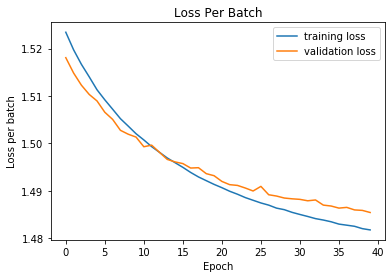

In [41]:
# plot loss for benchmark
plot_losses(train_loss_list[10:], valid_loss_list[10:], 'images/benchmark50-2.png')

### Sequence 1

[1/2, 1/3, 1/4, ...]

In [30]:
## update by epoch

# parameters
learning_rate = 0.01
num_epochs = 50
lr_seq = [1 / x * learning_rate for x in range(2, 60)]
PATH = 'models/seq1-epoch.pth'

cnnnet = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnnnet.parameters(), lr=learning_rate, momentum=0.9)
model, train_loss_list, valid_loss_list, train_accuracy_list, valid_accuracy_list, converge_time = train(cnnnet, PATH=PATH, lr_seq=lr_seq , num_epochs=num_epochs, by_epoch=True)     

epoch     1   train loss: 1.66948, train accuracy: 0.81626, valid loss: 1.53194, valid accuracy: 0.93591
Update learning rate! New learning rate is: 0.005000
epoch     2   train loss: 1.52606, train accuracy: 0.94161, valid loss: 1.51419, valid accuracy: 0.95223
Update learning rate! New learning rate is: 0.003333
epoch     3   train loss: 1.51319, train accuracy: 0.95336, valid loss: 1.50725, valid accuracy: 0.95850
Update learning rate! New learning rate is: 0.002500
epoch     4   train loss: 1.50678, train accuracy: 0.95954, valid loss: 1.50334, valid accuracy: 0.96208
Update learning rate! New learning rate is: 0.002000
epoch     5   train loss: 1.50287, train accuracy: 0.96290, valid loss: 1.50023, valid accuracy: 0.96507
Update learning rate! New learning rate is: 0.001667
epoch     6   train loss: 1.50017, train accuracy: 0.96565, valid loss: 1.49944, valid accuracy: 0.96497
Update learning rate! New learning rate is: 0.001429
epoch     7   train loss: 1.49819, train accuracy: 0

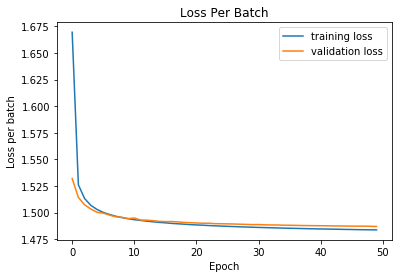

In [31]:
plot_losses(train_loss_list, valid_loss_list, 'images/seq1-epoch.png')

In [32]:
## update by cutoff

# parameters
learning_rate = 0.01
num_epochs = 50
lr_seq = [1 / x * learning_rate for x in range(2, 60)]
PATH = 'models/seq1-cutoff.pth'

cnnnet = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnnnet.parameters(), lr=learning_rate, momentum=0.9)
model, train_loss_list, valid_loss_list, train_accuracy_list, valid_accuracy_list, converge_time = train(cnnnet, PATH=PATH, lr_seq=lr_seq , num_epochs=num_epochs, by_cutoff=True)     

epoch     1   train loss: 1.73429, train accuracy: 0.74110, valid loss: 1.60543, valid accuracy: 0.85938
epoch     2   train loss: 1.55098, train accuracy: 0.91716, valid loss: 1.51057, valid accuracy: 0.95571
epoch     3   train loss: 1.50599, train accuracy: 0.96035, valid loss: 1.49565, valid accuracy: 0.96935
Update learning rate! New learning rate is: 0.005000
epoch     4   train loss: 1.49438, train accuracy: 0.97108, valid loss: 1.49251, valid accuracy: 0.97283
Update learning rate! New learning rate is: 0.003333
epoch     5   train loss: 1.49055, train accuracy: 0.97465, valid loss: 1.49036, valid accuracy: 0.97442
epoch     6   train loss: 1.48847, train accuracy: 0.97635, valid loss: 1.49031, valid accuracy: 0.97363
Update learning rate! New learning rate is: 0.002500
epoch     7   train loss: 1.48645, train accuracy: 0.97848, valid loss: 1.48785, valid accuracy: 0.97621
epoch     8   train loss: 1.48529, train accuracy: 0.97953, valid loss: 1.48751, valid accuracy: 0.97711
e

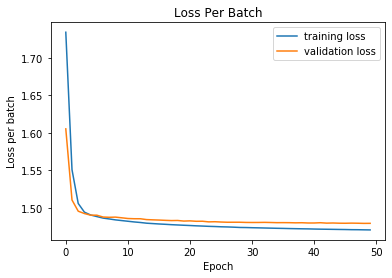

In [33]:
plot_losses(train_loss_list, valid_loss_list, 'images/seq1-cutoff.png')

In [67]:
## update by oscillate

# parameters
learning_rate = 0.01
num_epochs = 50
lr_seq = [1 / x * learning_rate for x in range(2, 60)]
PATH = 'models/seq1-oscillate.pth'

cnnnet = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnnnet.parameters(), lr=learning_rate, momentum=0.9)
model, train_loss_list, valid_loss_list, train_accuracy_list, valid_accuracy_list, converge_time = train(cnnnet, PATH=PATH, lr_seq=lr_seq , num_epochs=num_epochs, by_oscillate=True)     

epoch     1   train loss: 1.69170, train accuracy: 0.80527, valid loss: 1.52852, valid accuracy: 0.94277
Update learning rate! New learning rate is: 0.005000
epoch     2   train loss: 1.52350, train accuracy: 0.94488, valid loss: 1.51225, valid accuracy: 0.95412
epoch     3   train loss: 1.51064, train accuracy: 0.95639, valid loss: 1.50535, valid accuracy: 0.96049
epoch     4   train loss: 1.50226, train accuracy: 0.96429, valid loss: 1.50055, valid accuracy: 0.96377
epoch     5   train loss: 1.49651, train accuracy: 0.96933, valid loss: 1.49458, valid accuracy: 0.96925
epoch     6   train loss: 1.49254, train accuracy: 0.97256, valid loss: 1.49127, valid accuracy: 0.97333
epoch     7   train loss: 1.48935, train accuracy: 0.97555, valid loss: 1.49100, valid accuracy: 0.97323
epoch     8   train loss: 1.48666, train accuracy: 0.97829, valid loss: 1.48741, valid accuracy: 0.97631
epoch     9   train loss: 1.48450, train accuracy: 0.97999, valid loss: 1.48596, valid accuracy: 0.97721
ep

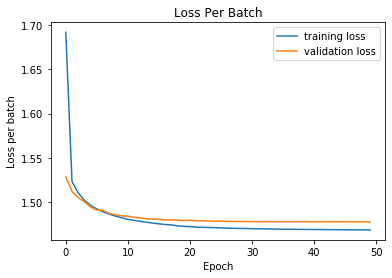

In [68]:
plot_losses(train_loss_list, valid_loss_list, 'images/seq1-oscillate.png')

### Sequence 2
[1/sqrt(2), 1/sqrt(3), ...]

In [35]:
## update by epoch

# parameters
learning_rate = 0.01
num_epochs = 50
lr_seq = [1 / (x**0.5) * learning_rate for x in range(2, 60)]
PATH = 'models/seq2-epoch.pth'

cnnnet = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnnnet.parameters(), lr=learning_rate, momentum=0.9)
model, train_loss_list, valid_loss_list, train_accuracy_list, valid_accuracy_list, converge_time = train(cnnnet, PATH=PATH, lr_seq=lr_seq , num_epochs=num_epochs, by_epoch=True)     

epoch     1   train loss: 1.71801, train accuracy: 0.77514, valid loss: 1.59983, valid accuracy: 0.86684
Update learning rate! New learning rate is: 0.007071
epoch     2   train loss: 1.59705, train accuracy: 0.86825, valid loss: 1.58765, valid accuracy: 0.87500
Update learning rate! New learning rate is: 0.005774
epoch     3   train loss: 1.58695, train accuracy: 0.87748, valid loss: 1.58122, valid accuracy: 0.88087
Update learning rate! New learning rate is: 0.005000
epoch     4   train loss: 1.51666, train accuracy: 0.95221, valid loss: 1.50190, valid accuracy: 0.96387
Update learning rate! New learning rate is: 0.004472
epoch     5   train loss: 1.49925, train accuracy: 0.96735, valid loss: 1.49628, valid accuracy: 0.96935
Update learning rate! New learning rate is: 0.004082
epoch     6   train loss: 1.49378, train accuracy: 0.97230, valid loss: 1.49191, valid accuracy: 0.97233
Update learning rate! New learning rate is: 0.003780
epoch     7   train loss: 1.49026, train accuracy: 0

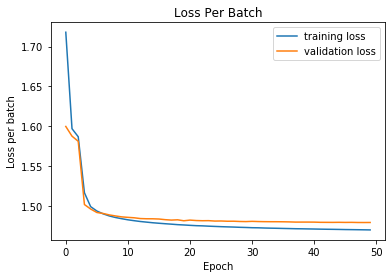

In [36]:
plot_losses(train_loss_list, valid_loss_list, 'images/seq2-epoch.png')

In [37]:
## update by cutoff

# parameters
learning_rate = 0.01
num_epochs = 50
lr_seq = [1 / (x**0.5) * learning_rate for x in range(2, 60)]
PATH = 'models/seq2-cutoff.pth'

cnnnet = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnnnet.parameters(), lr=learning_rate, momentum=0.9)
model, train_loss_list, valid_loss_list, train_accuracy_list, valid_accuracy_list, converge_time = train(cnnnet, PATH=PATH, lr_seq=lr_seq , num_epochs=num_epochs, by_cutoff=True)     

epoch     1   train loss: 1.70439, train accuracy: 0.78167, valid loss: 1.54699, valid accuracy: 0.92128
epoch     2   train loss: 1.53106, train accuracy: 0.93567, valid loss: 1.51463, valid accuracy: 0.95183
epoch     3   train loss: 1.50900, train accuracy: 0.95697, valid loss: 1.49992, valid accuracy: 0.96586
Update learning rate! New learning rate is: 0.007071
epoch     4   train loss: 1.49776, train accuracy: 0.96757, valid loss: 1.49471, valid accuracy: 0.96945
epoch     5   train loss: 1.49199, train accuracy: 0.97316, valid loss: 1.49064, valid accuracy: 0.97343
epoch     6   train loss: 1.48814, train accuracy: 0.97668, valid loss: 1.49035, valid accuracy: 0.97482
Update learning rate! New learning rate is: 0.005774
epoch     7   train loss: 1.48459, train accuracy: 0.97986, valid loss: 1.48826, valid accuracy: 0.97572
epoch     8   train loss: 1.48263, train accuracy: 0.98158, valid loss: 1.48690, valid accuracy: 0.97711
epoch     9   train loss: 1.48078, train accuracy: 0.9

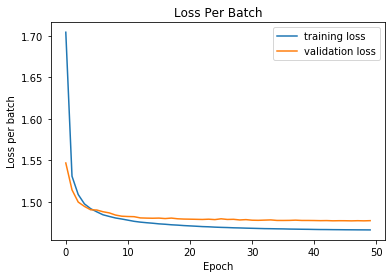

In [38]:
plot_losses(train_loss_list, valid_loss_list, 'images/seq2-cutoff.png')

In [39]:
## update by oscillate

# parameters
learning_rate = 0.01
num_epochs = 50
lr_seq = [1 / (x**0.5) * learning_rate for x in range(2, 60)]
PATH = 'models/seq2-oscillate.pth'

cnnnet = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnnnet.parameters(), lr=learning_rate, momentum=0.9)
model, train_loss_list, valid_loss_list, train_accuracy_list, valid_accuracy_list, converge_time = train(cnnnet, PATH=PATH, lr_seq=lr_seq , num_epochs=num_epochs, by_oscillate=True)     

epoch     1   train loss: 1.70653, train accuracy: 0.78117, valid loss: 1.53759, valid accuracy: 0.92974
Update learning rate! New learning rate is: 0.007071
epoch     2   train loss: 1.52786, train accuracy: 0.93923, valid loss: 1.51699, valid accuracy: 0.94944
epoch     3   train loss: 1.51020, train accuracy: 0.95637, valid loss: 1.50297, valid accuracy: 0.96178
epoch     4   train loss: 1.50043, train accuracy: 0.96535, valid loss: 1.49514, valid accuracy: 0.96945
epoch     5   train loss: 1.49430, train accuracy: 0.97115, valid loss: 1.49138, valid accuracy: 0.97193
epoch     6   train loss: 1.48985, train accuracy: 0.97476, valid loss: 1.48978, valid accuracy: 0.97432
epoch     7   train loss: 1.48646, train accuracy: 0.97800, valid loss: 1.48673, valid accuracy: 0.97681
epoch     8   train loss: 1.48409, train accuracy: 0.98016, valid loss: 1.48629, valid accuracy: 0.97791
epoch     9   train loss: 1.48210, train accuracy: 0.98174, valid loss: 1.48466, valid accuracy: 0.97880
ep

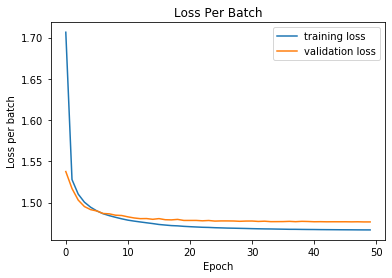

In [40]:
plot_losses(train_loss_list, valid_loss_list, 'images/seq2-oscillate.png')

### Adam

In [35]:
# parameters
learning_rate = 0.001
num_epochs = 50
lr_seq = []
PATH = 'models/benchmark-adam50.pth'

cnnnet = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnnnet.parameters(), lr=learning_rate)
model, train_loss_list, valid_loss_list, train_accuracy_list, valid_accuracy_list, converge_time = train(cnnnet, PATH=PATH, lr_seq=lr_seq , num_epochs=num_epochs)     

epoch     1   train loss: 1.57326, train accuracy: 0.89920, valid loss: 1.49869, valid accuracy: 0.96547
epoch     2   train loss: 1.49566, train accuracy: 0.96802, valid loss: 1.49670, valid accuracy: 0.96626
epoch     3   train loss: 1.48635, train accuracy: 0.97640, valid loss: 1.48646, valid accuracy: 0.97611
epoch     4   train loss: 1.48171, train accuracy: 0.98078, valid loss: 1.48227, valid accuracy: 0.97920
epoch     5   train loss: 1.47845, train accuracy: 0.98369, valid loss: 1.47987, valid accuracy: 0.98209
epoch     6   train loss: 1.47625, train accuracy: 0.98576, valid loss: 1.48026, valid accuracy: 0.98139
epoch     7   train loss: 1.47447, train accuracy: 0.98747, valid loss: 1.47911, valid accuracy: 0.98288
epoch     8   train loss: 1.47306, train accuracy: 0.98869, valid loss: 1.47823, valid accuracy: 0.98318
epoch     9   train loss: 1.47139, train accuracy: 0.99051, valid loss: 1.47801, valid accuracy: 0.98318
epoch    10   train loss: 1.47057, train accuracy: 0.99

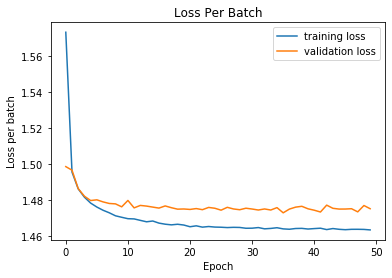

In [37]:
plot_losses(train_loss_list, valid_loss_list, 'images/benchmark-adam50.png')

## Comparison

### Comparison among four sequences

For each strategy(epoch, cutoff, oscillate), compare the result of four sequences and the benchmark.

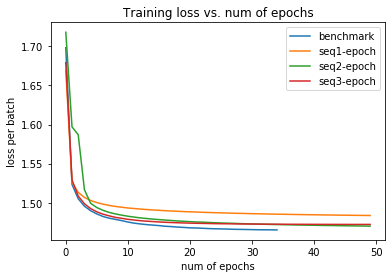

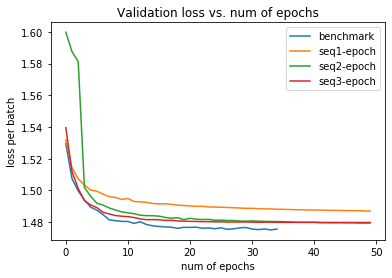

In [11]:
# when by epoch, comparison among four seqs
model_list = ['models/benchmark.pth', 'models/seq1-epoch.pth', 'models/seq2-epoch.pth', 
             'models/seq3-epoch.pth']
plot_comparison(model_list, plot_train=True, start=0)
plot_comparison(model_list, plot_train=False, start=0)

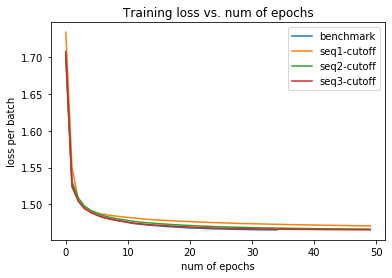

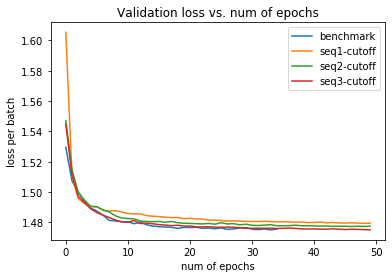

In [12]:
# when by cutoff, comparison among four seqs
model_list = ['models/benchmark.pth', 'models/seq1-cutoff.pth', 'models/seq2-cutoff.pth', 
             'models/seq3-cutoff.pth']
plot_comparison(model_list, plot_train=True, start=0)
plot_comparison(model_list, plot_train=False, start=0)

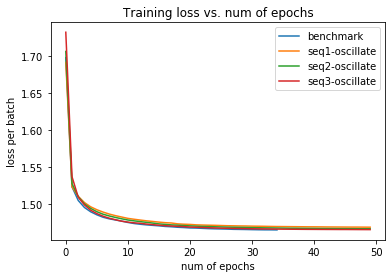

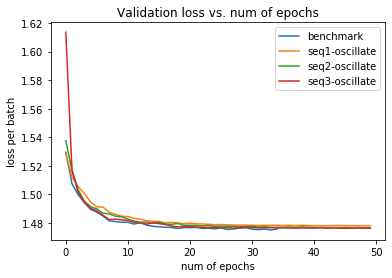

In [13]:
# when by oscillate, comparison among four seqs
model_list = ['models/benchmark.pth', 'models/seq1-oscillate.pth', 'models/seq2-oscillate.pth', 
             'models/seq3-oscillate.pth']
plot_comparison(model_list, plot_train=True, start=0)
plot_comparison(model_list, plot_train=False, start=0)

### Comparison among three strategies
For each sequence(seq1, seq2, seq3), compare the result of three strategies and the benchmark.

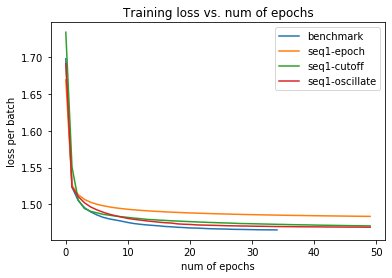

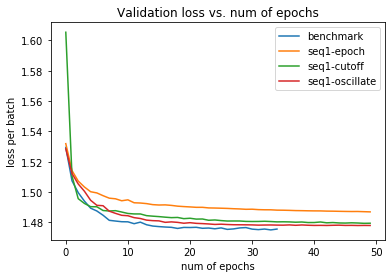

In [14]:
# when using seq1, comparison among three strategies
model_list = ['models/benchmark.pth', 'models/seq1-epoch.pth', 'models/seq1-cutoff.pth', 
             'models/seq1-oscillate.pth']
plot_comparison(model_list, plot_train=True, start=0)
plot_comparison(model_list, plot_train=False, start=0)

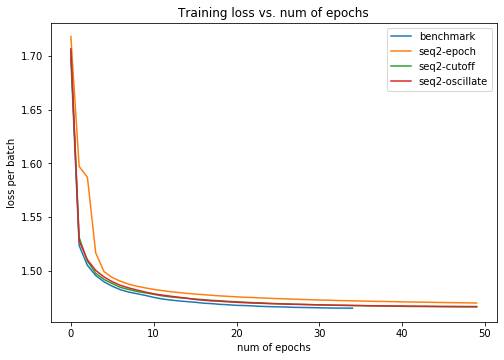

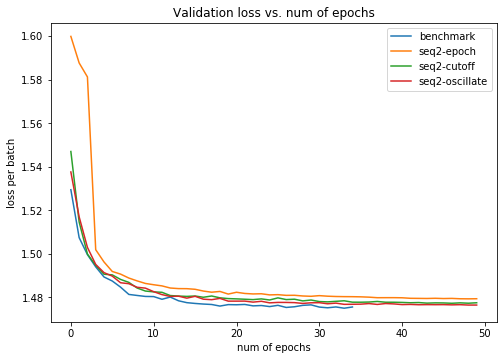

In [26]:
# when using seq2, comparison among three strategies
model_list = ['models/benchmark.pth', 'models/seq2-epoch.pth', 'models/seq2-cutoff.pth', 
             'models/seq2-oscillate.pth']
plot_comparison(model_list, plot_train=True, start=0)
plot_comparison(model_list, plot_train=False, start=0)

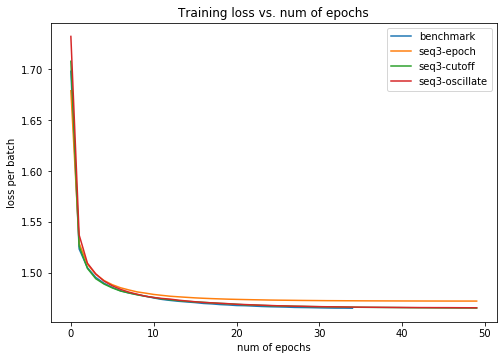

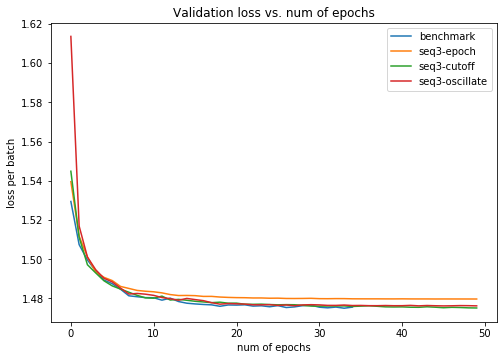

In [27]:
# when using seq3, comparison among three strategies
model_list = ['models/benchmark.pth', 'models/seq3-epoch.pth', 'models/seq3-cutoff.pth', 
             'models/seq3-oscillate.pth']
plot_comparison(model_list, plot_train=True, start=0)
plot_comparison(model_list, plot_train=False, start=0)

### Comparison between SGD and Adam benchmark

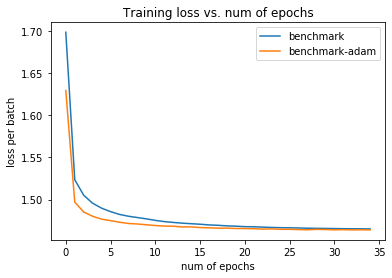

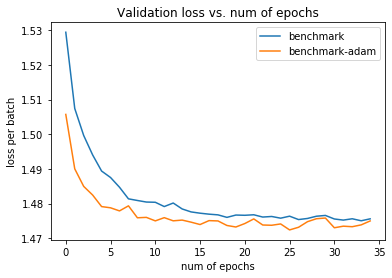

In [17]:
# compare SGD and Adam
model_list = ['models/benchmark.pth', 'models/benchmark-adam.pth']
plot_comparison(model_list, plot_train=True, start=0)
plot_comparison(model_list, plot_train=False, start=0)

### Comparison among optimal combinations and benchmarks

For each sequence, pick the best performing strategy. Compare these optimal combinations with two benchmarks.
- seq1-oscillate
- seq2-oscillate(seq2-cutoff is close)
- seq3-oscillate(seq3-cutoff is close)
- SGD benchmark
- Adam benchmark

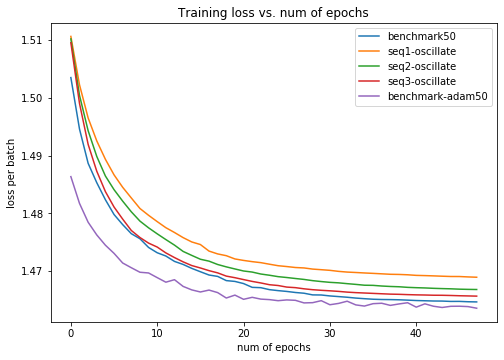

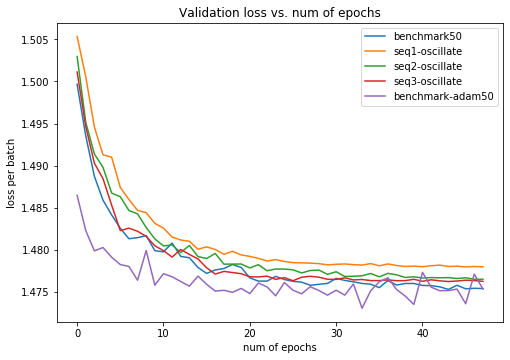

In [38]:
# plot comparison
model_list = ['models/benchmark50.pth', 'models/seq1-oscillate.pth', 'models/seq2-oscillate.pth', 
             'models/seq3-oscillate.pth', 'models/benchmark-adam50.pth']
plot_comparison(model_list, plot_train=True, start=2)
plot_comparison(model_list, plot_train=False, start=2)